# Sander van de Kamp
#### 500734351 
#### 17/03/2021
# Salary prediction per field

In [20]:
# imports
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
from scipy.stats import zscore
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import pandas as pd

# analyse
### probleem

Voor deze dataset wil ik het salaris voor werknemers gaan voorspellen aan de hand van de meeste labels in de dataset, hiervoor zal er gekeken worden naar het geslacht, opleiding en specialisatie.

### dimensies

Het is een kleine dataset van maar 215 rijen met 15 kolommen

### features

De dataset bestaad voor de helft uit float getallen en de andere helft bestaat uit strings









In [22]:
# link: https://www.kaggle.com/benroshan/factors-affecting-campus-placement
df = pd.read_csv('Placement_Data_Full_class.csv');
print('number of rows: {}'.format(len(df)));
print('number of cols: {}'.format(len(df.columns)));

print(df.dtypes);
print(df.head());

number of rows: 215
number of cols: 15
sl_no               int64
gender             object
ssc_p             float64
ssc_b              object
hsc_p             float64
hsc_b              object
hsc_s              object
degree_p          float64
degree_t           object
workex             object
etest_p           float64
specialisation     object
mba_p             float64
status             object
salary            float64
dtype: object
   sl_no gender  ssc_p    ssc_b  hsc_p    hsc_b     hsc_s  degree_p  \
0      1      M  67.00   Others  91.00   Others  Commerce     58.00   
1      2      M  79.33  Central  78.33   Others   Science     77.48   
2      3      M  65.00  Central  68.00  Central      Arts     64.00   
3      4      M  56.00  Central  52.00  Central   Science     52.00   
4      5      M  85.80  Central  73.60  Central  Commerce     73.30   

    degree_t workex  etest_p specialisation  mba_p      status    salary  
0   Sci&Tech     No     55.0         Mkt&HR  58.80     

### Visualisatie
De verdeling van het salaris bevat als enige kolom een paar groote outliers (is te zien dat het ver buiten de max van de boxplot ligt)

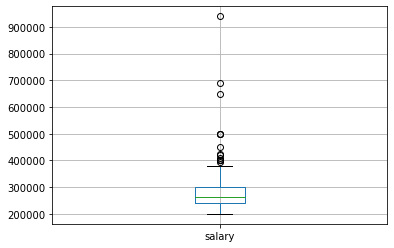

In [24]:
df[['salary']].boxplot()


# voorspelling
### Classifiers

Gebaseerd op wat scikitlearn suggereerd voor een regressor met weinig data zou de Stochastig Gradient Descent (SGD) Regressor het beste zijn voor een regressie met weinig waardes, de SGD Regressor is in principe een lineaire regressie met een andere optimalisatie functie die het efficiënter. Gebaseerd op mijn vorige regressie modellen is een lineare regressor ook meestal de beste, hierom zou ik ook voor een versie van lineare regressie gaan.

### Hyperparams

Voor de SGD regressor zou er gekeken moeten worden naar de max_iteraties, penalty en de alpha waardes, de alpha waardes zijn belangrijk voor de sterkte van de regressie (hoe snel het aanpast naar de correcte hoek en plaats), de penalty die bepaald hoe erg de fout is die de regressie maakt en de max iteraties bepaald hoe vaak de regressor over de data heen mag kijken.

In [26]:
sgd_params = {
    'penalty': [ 'L1', 'L2', 'elasticnet'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [50, 75, 100, 125, 150]
}

# methoden
### Preprocessing

De texten moeten omgezet worden naar labels via de labelencoder, de rijen waarbij de status "non placed" was moeten weggelaten worden aangezien die niet werken en de sl_no kolom moet weggehaald worden aangezien dat de index is voor elke rij. De getllan kolommen moeten ook omgezet worden naar z scores aangezien sommige kolommen grotere verschillen hebben dan andere, waardoor het ervoor kan zorgen dat sommige kolommen zwaarder meetellen dan zou moeten. Om dit op te lossen moeten er Z-scores gebruikt worden die de afwijken van het gemiddelde aangeven, hierdoor zal de grootte van de waarde geen invloed meer hebben op de uitkomst. Ook zullen de waardes met een lage correlatie weggelaten worden. De salaris kolom heeft ook twee grote outliers die ver van de rest van de waardes zitten (meer dan het dubbelel), hierom zal er voor deze twee waardes de mediaan genomen worden van de data.

### classifiers vergelijken

De classifiers die met de SGD vergelijken gaan worden zijn de Random Forest Regressor en de SVM Regressor, volgens de sklearn estimator suggesties is de SVM ook een redelijke regressor en de Random Forest en SVM Regressors hebben ook een vrij hoge accuraatheid. voor elke classifier zal grid search gebruikt worden met de leave one out validation, aangezien er weinig waardes zijn.

### performance metric

De performance metric die gebruikt moet worden is r2 om te bepalen hoe groot de fout is bij elke voorspelling.

In [28]:
# preproccesing
# # drop irrelevante columns
df = df[df.status == 'Placed'];

# drop irrelevante index
df.drop(['sl_no', 'status'], axis = 1, inplace = True);

# pak kolommen die z-score of labels moeten worden
encoding_columns = df.select_dtypes(include = 'object').columns;
z_score_columns = df.select_dtypes(include = 'float').columns;

# outliers in salaris vervangen met mediaan
df['salary'].values[df['salary'] > df['salary'].quantile(0.75)] = df['salary'].median()


# encode labels
encoder = LabelEncoder();

# loop door alle kolommen heen met text erin
for col in encoding_columns:
    encoder.fit(df[col]);
    df[col] = encoder.transform(df[col]);

# z-score voor labels
for col in z_score_columns[0:5]: #skip salaris
    df[col] = zscore(df[col])

# correlatie matrix laten zien om te kijken welke waardes weg kunnen
print(df.corr())

# haal de voorspelde waarde uit de dataset
print(df.salary.max())
df_outcome = df['salary']
df.drop(['ssc_p', 'ssc_b', 'hsc_p', 'hsc_b', 'hsc_s', 'degree_p', 'degree_p', 'salary'], axis = 1, inplace = True)

# maak train/test data
X_train, X_test, y_train, y_test = train_test_split(df, df_outcome, test_size = 0.3, random_state = 42)

                  gender     ssc_p     ssc_b     hsc_p     hsc_b     hsc_s  \
gender          1.000000 -0.175577 -0.008595 -0.023683  0.044892  0.012454   
ssc_p          -0.175577  1.000000  0.199567  0.293416  0.141686  0.271656   
ssc_b          -0.008595  0.199567  1.000000 -0.132643  0.638512  0.072982   
hsc_p          -0.023683  0.293416 -0.132643  1.000000 -0.053084 -0.247155   
hsc_b           0.044892  0.141686  0.638512 -0.053084  1.000000  0.171222   
hsc_s           0.012454  0.271656  0.072982 -0.247155  0.171222  1.000000   
degree_p       -0.197983  0.380657  0.099129  0.221307  0.074791  0.157694   
degree_t        0.035846  0.251567  0.119069 -0.090956  0.054563  0.637800   
workex          0.080317  0.066050 -0.143969 -0.012101  0.018180  0.056879   
etest_p         0.126781  0.317892  0.098825  0.284672  0.043846  0.050984   
specialisation -0.084620 -0.079013 -0.030134 -0.147356 -0.017024  0.139671   
mba_p          -0.240746  0.430560  0.099025  0.329983  0.057165

In [29]:
# classifiers vergelijken
sgd = SGDRegressor();
sgd_grid = GridSearchCV(sgd, sgd_params, cv = LeaveOneOut(), n_jobs = -1);
sgd_grid.fit(X_train, y_train);
print('best params: {}'.format(sgd_grid.best_params_));

best params: {'alpha': 0.0001, 'max_iter': 50, 'penalty': 'L1'}
D:\Anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [30]:
# SVM regressor
svr = SVR();

svr_params = {
    'kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
    'C' : [0.001, 0.01, 0.1, 1, 10, 100]
}

svr_grid = GridSearchCV(svr, svr_params, cv = LeaveOneOut(), n_jobs = -1);
svr_grid.fit(X_train, y_train);
print('best params: {}'.format(svr_grid.best_params_));

best params: {'C': 0.001, 'kernel': 'linear'}


In [31]:
# random forest regressor
forest = RandomForestRegressor();

forest_params = {
    'n_estimators': [10 ,25, 50, 100],
    'max_depth': [1, 2, 3, 4, 5],
    'max_leaf_nodes': [10, 25, 50, 100, None]
}

forest_grid = GridSearchCV(forest, forest_params, cv = LeaveOneOut(), n_jobs = -1);
forest_grid.fit(X_train, y_train);
print('best params: {}'.format(forest_grid.best_params_));

best params: {'max_depth': 1, 'max_leaf_nodes': 10, 'n_estimators': 10}


# resultaten
### previous results
SGD Regressor R2 score of -0.15

SVM Regressor R2 sore of -0.11

RFT regressor R2 score of -0.10

Ik heb de aan de hand van de correlation matrix de waardes weggehaald met een lage correlatie en de outliers in salaris weggehaald die ik zag na het plotten van de lijn.

In [33]:
print('SGD Regressor R2 score:{}'.format(r2_score(y_test, sgd_grid.predict(X_test))))
print('SVM Regressor R2 score:{}'.format(r2_score(y_test, svr_grid.predict(X_test))))
print('random forest regressor R2 score:{}'.format(r2_score(y_test, forest_grid.predict(X_test))))

SGD Regressor R2 score:-0.6089802629454952
SVM Regressor R2 score:-0.11171992968644862
random forest regressor R2 score:-0.2088006754466729


### Regression visualisaties
De r2 score is vrij slecht, alleen komt dit niet doordat het slecht voorspeld. De datapunten liggen ver uit elkaar waardoor de r2 score niet goed is, maar de lijn past er wel goed op in vergelijking met de datapunten.

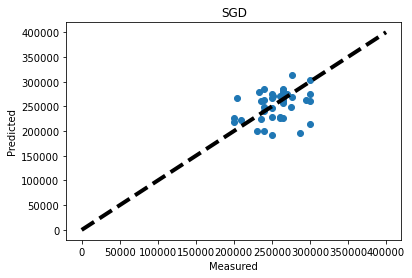

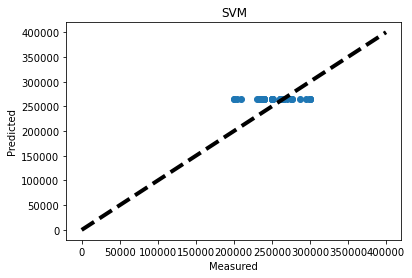

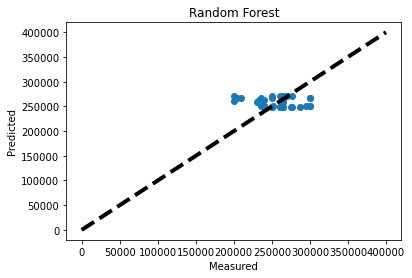

In [34]:
predicted = sgd_grid.predict(X_test)
predicted_svm = svr_grid.predict(X_test)
predicted_forest = forest_grid.predict(X_test)

fig, ax = plt.subplots()
ax.scatter(y_test, predicted)
ax.plot([175000, 350000], [175000, 350000], 'k--', lw = 4)
ax.set_title('SGD')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


fig, ax = plt.subplots()
ax.scatter(y_test, predicted_svm)
ax.plot([175000, 350000], [175000, 350000], 'k--', lw = 4)
ax.set_title('SVM')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()


fig, ax = plt.subplots()
ax.scatter(y_test, predicted_forest)
ax.plot([175000, 350000], [175000, 350000], 'k--', lw = 4)
ax.set_title('Random Forest')
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# evaluatie
De SGD was zoals verwacht de beste classifier voor dit regressie model, de andere twee vergeleken modellen passen vrij slecht.
Het aanpassen van de kolommen die allemaal meegenomen werden met het trainen verbeterde het model ook flink, waarbij de kolommen met een erg lage correlatie ook een negatief effect hadden op het uiteindelijke output.

# literatuurverwijzingen
Kies de juiste classifier:
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Uitlieg voor SGD Regressor:
https://scikit-learn.org/stable/modules/sgd.html

SGDRegressor sklearn:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

SVM Regressor sklearn:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

Random Forest Regressor sklearn: 
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Leave One Out sklearn:
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html